In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Reshape, Dropout, Flatten, Lambda
from keras.layers import Conv2DTranspose, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, UpSampling2D, UpSampling1D 
from keras.layers import LocallyConnected1D, LocallyConnected2D, LSTM, RepeatVector
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
n = 2
dim4 = True
multiTrack = True
context, x_train, labels = data.import_data(data.init(), n, dim4=dim4, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/simple-straight-120.mid
 [INFO] : 
 |  reading file: ../datasets/examples/simple-shuffle-120.mid

Encoding midi-data
 [<midi file '../datasets/examples/simple-straight-120.mid' type 0, 1 tracks, 68 messages>, <midi file '../datasets/examples/simple-shuffle-120.mid' type 0, 1 tracks, 68 messages>]
> -> multi-track = True
 [INFO] : 
 |  reduced dims:
 |  (2, 100, 1)


In [5]:
n = 1000
min_f = 0
max_f = 3
x_train, params = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f,
    n_polyrythms=1,
    n_channels=3,
    d_phase=True,
    return_params=True,
    dim4=dim4,
    multiTrack=multiTrack)

 [INFO] : 
 |  reduced dims:
 |  (1000, 100, 3)


In [6]:
x_train.shape

(1000, 100, 3, 1)

In [7]:
m = int(x_train.shape[0] * 0.9)
[x_train.shape, m]

[(1000, 100, 3, 1), 900]

In [8]:
x_test = x_train[m:]
x_train = x_train[:m]

m (50, 3)


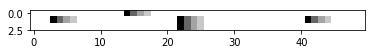

m (50, 3)


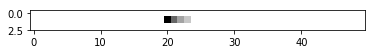

m (50, 3)


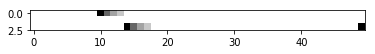

In [38]:
plot.single(x_train[0, :50,:,0])
plot.single(x_train[1, :50,:,0])
plot.single(x_train[2, :50,:,0])

In [10]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(100, 3, 1)

In [11]:
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0

In [86]:
def encoder(input_size, dropout=0.1):
    encoder_input = Input(shape=input_size)
    
    # Convolve & Pool
    h = encoder_input
    h = Reshape(input_shape[:-1])(h)
    h = Conv1D(32, kernel_size=2, strides=2, activation='relu', padding='same')(h)
    h = Conv1D(32, kernel_size=2, strides=1, activation='elu', padding='same')(h)
    h = Conv1D(64, kernel_size=2, strides=2, activation='relu', padding='same')(h)
#     h = Conv1D(64, kernel_size=2, strides=1, activation='relu', padding='same')(h)
#     #     x = AveragePooling2D((2, 2))(x)
#     h = Conv1D(128, kernel_size=2, strides=2, activation='relu', padding='same')(h)

    # Dense layers
    h = Dropout(dropout)(h) # uncomment when using larger batches
    h = Flatten()(h)
    h = Dropout(dropout)(h) # uncomment when using larger batches

    h = Dense(intermediate_dim, activation='relu')(h)
   
    # Z Mean, Variance
    z_mean = Dense(latent_dim, name='z_mean')(h) # , activation='relu'
    z_log_var = Dense(latent_dim, name='z_log_var')(h) # , activation='relu'
        
    encoder_output = [z_mean, z_log_var]
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model-')
    return encoder_model, encoder_input, z_mean, z_log_var

In [88]:
encoder_model, encoder_input, z_mean, z_log_var = encoder(input_shape)
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 100, 3, 1)    0                                            
__________________________________________________________________________________________________
reshape_7 (Reshape)             (None, 100, 3)       0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 50, 32)       224         reshape_7[0][0]                  
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 50, 32)       2080        conv1d_10[0][0]                  
__________________________________________________________________________________________________
conv1d_12 

In [89]:
sample_ = lambda args: models.sample(args, z_mean, z_log_var, latent_dim, epsilon_std)

In [90]:
# z = Lambda(sampling)([z_mean, z_log_var])
z_input = encoder_model(encoder_input)
z_output = Lambda(sample_)(z_input)

In [91]:
def list_decoders(output_size, p='valid'):
    # decoder_input = z_output
    # h = decoder_input
    # :output_shape = (timesteps, channels, channels) || (batches, filters, timesteps, channels)
    # keras offers just Conv2DTranspose and not Conv1DTranspose
    # - use 2D images during upsampling :: (timesteps, notes, channels) => (timesteps, notes, filters)
    # - use 1D images to optimize reconstruction :: (timesteps, filters) => (timesteps, notes)
    
    # image_data_format = 'channels_last'
    # goal shape: (timesteps, notes, channels)
    # start with the 'reverse': lots of small imgs => few large img
    
    timesteps, notes, channels = output_size
    m = 4 # multiplier for dims
    
    # at the start of upsampling, the image-structure does not yet have to correspond to the goal structure 
    # ?TODO use y*y*y starting dims, may conv, and only then correct the structure (?)
    output_shape = (timesteps, notes, channels)
    
    # we instantiate these layers separately so as to reuse them later
    decoders = []
    decoders += [ Dense(intermediate_dim, activation='relu') ]
    decoders += [ Dense(np.prod(output_shape), activation='relu') ]
    decoders += [ Dense(np.prod(output_shape), activation='relu') ]

#     decoders += [ Reshape(output_shape[-3:]) ]
    
    # Convolve & Pool
    
    # Note that the kernel windows do not yet correspond to 'temporal' features, but rather to just spatial features
    k = (3,2) # (2,1) :: (timesteps, notes)
    s = (1,3)
    timesteps_ = int(timesteps / 2)
    
#     decoders += [ Conv2DTranspose(timesteps_, kernel_size=k, strides=3, activation='relu', padding=p) ]
#     decoders += [ Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p) ]
#     # decoder += [Conv2DTranspose(32, kernel_size=k, strides=3, activation='relu', padding=p)]
#     decoders += [ Conv2DTranspose(16, kernel_size=k, strides=(3,1), activation='relu', padding=p)]
#     decoders += [ Conv2DTranspose(16, kernel_size=k, strides=3, activation='relu', padding=p)]
    
    # 'end' of upsampling
#     decoders += [ Conv2D(1, kernel_size=(1,2), strides=1, activation='relu', padding=p) ]
    # shape = ()
    # decoder_reshape2 = Reshape(dims[0:2])
    # #     h = Conv1D(16, kernel_size=2, strides=1, activation='relu', padding=p)(h)
    # decoder_conv2 = Conv1D(notes * m, kernel_size=2, strides=2, activation='relu', padding=p)
    
    
    # Mean (output)
    #     h = Conv2D(1, kernel_size=1, strides=s, activation='sigmoid', padding='same')(h)
    output_shape = (timesteps, notes, channels)
    
#     decoders += [ Flatten()] # note that [].append != [] = []
    decoders += [ Dense(np.prod(output_shape), activation='sigmoid')]
    decoders += [ Reshape(output_shape)]
    return decoders

In [92]:
decoders = list_decoders(input_shape)

In [93]:
decoded = utils.composition(decoders, z_output, verbose=False)

In [94]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 100, 3, 1)    0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 2), (None, 2 211908      input_7[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 2)            0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 128)          384         lambda_4[0][0]                   
__________

In [95]:
# Compute VAE loss
def vae_loss(beta=1.):
    # y_true, y_pred, z_mean, z_log_var, timesteps=150, notes=3, beta=1.
    xent_loss = timesteps * notes * keras.metrics.binary_crossentropy(K.flatten(vae_input), K.flatten(vae_output))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + beta * kl_loss)
    return vae_loss

vae_loss = vae_loss(beta=0.2)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Output "reshape_8" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_8" during training.
  # This is added back by InteractiveShellApp.init_path()


In [96]:
batch_size = 100
epochs = 10
params = {'batch_size': batch_size, 'return_y': False}

In [97]:
phase_mod = 0.01
whitening = False

# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by dataset std
#         samplewise_std_normalization=False,  # divide each input by its std
# #         zca_epsilon=10,
#         zca_whitening=whitening,
#         rotation_range=0,  # randomly rotate images in 0 to 180 degrees
#         width_shift_range=0.,  # note-channel mod, but not shuffled
#         height_shift_range=phase_mod,  # start_t, phase
#         horizontal_flip=False,  # reverse
#         vertical_flip=False)

# # datagen.fit(x_train)

In [98]:
x_train.shape

(900, 100, 3, 1)

In [99]:
m = 100
useDataGenerator = False
useDataGenerator = True

print('batch_size =', batch_size)
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('\n[Epoch %i/%i] >>>>>>>>>>>>\n' % (e, epochs))
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x_train[:m], x_train[:m], batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x = x_batch
#             x = datagen.shuffle_3rd_dim(x_batch)
            h = vae.fit(x, verbose=1)
            for k,v in h.history.items(): 
                history[k].append(v)
            if batch_i >= n_batches:
                break
else:
    h = vae.fit(x_train[:m], epochs=epochs, validation_data=(x_test, None))
    history = h.history

batch_size = 100

[Epoch 0/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
100/100 [==============================] - 0s 5ms/step - loss: 194.8350
 Batch 1/9
Epoch 1/1
100/100 [==============================] - 0s 495us/step - loss: 112.4575
 Batch 2/9
Epoch 1/1
100/100 [==============================] - 0s 710us/step - loss: 94.5236
 Batch 3/9
Epoch 1/1
100/100 [==============================] - 0s 542us/step - loss: 95.9763
 Batch 4/9
Epoch 1/1
100/100 [==============================] - 0s 659us/step - loss: 87.3500
 Batch 5/9
Epoch 1/1
100/100 [==============================] - 0s 577us/step - loss: 84.9849
 Batch 6/9
Epoch 1/1
100/100 [==============================] - 0s 687us/step - loss: 83.7682
 Batch 7/9
Epoch 1/1
100/100 [==============================] - 0s 552us/step - loss: 82.3200
 Batch 8/9
Epoch 1/1
100/100 [==============================] - 0s 708us/step - loss: 79.5477
 Batch 9/9
Epoch 1/1
100/100 [==============================] - 0s 637us/step - loss: 77.0882

[Epoch 1/100]

100/100 [==============================] - 0s 482us/step - loss: 69.1186
 Batch 5/9
Epoch 1/1
100/100 [==============================] - 0s 507us/step - loss: 68.9129
 Batch 6/9
Epoch 1/1
100/100 [==============================] - 0s 481us/step - loss: 69.6066
 Batch 7/9
Epoch 1/1
100/100 [==============================] - 0s 535us/step - loss: 69.5188
 Batch 8/9
Epoch 1/1
100/100 [==============================] - 0s 533us/step - loss: 68.9319
 Batch 9/9
Epoch 1/1
100/100 [==============================] - 0s 527us/step - loss: 69.8677

[Epoch 9/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
100/100 [==============================] - 0s 535us/step - loss: 68.7733
 Batch 1/9
Epoch 1/1
100/100 [==============================] - 0s 633us/step - loss: 68.9135
 Batch 2/9
Epoch 1/1
100/100 [==============================] - 0s 579us/step - loss: 70.3078
 Batch 3/9
Epoch 1/1
100/100 [==============================] - 0s 503us/step - loss: 68.5948
 Batch 4/9
Epoch 1/1
100/100 [======================

100/100 [==============================] - 0s 460us/step - loss: 63.0231
 Batch 9/9
Epoch 1/1
100/100 [==============================] - 0s 518us/step - loss: 63.0571

[Epoch 17/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
100/100 [==============================] - 0s 477us/step - loss: 62.7570
 Batch 1/9
Epoch 1/1
100/100 [==============================] - 0s 535us/step - loss: 63.0857
 Batch 2/9
Epoch 1/1
100/100 [==============================] - 0s 499us/step - loss: 62.7413
 Batch 3/9
Epoch 1/1
100/100 [==============================] - 0s 481us/step - loss: 63.1582
 Batch 4/9
Epoch 1/1
100/100 [==============================] - 0s 529us/step - loss: 62.9587
 Batch 5/9
Epoch 1/1
100/100 [==============================] - 0s 512us/step - loss: 62.5460
 Batch 6/9
Epoch 1/1
100/100 [==============================] - 0s 479us/step - loss: 62.5691
 Batch 7/9
Epoch 1/1
100/100 [==============================] - 0s 533us/step - loss: 62.2686
 Batch 8/9
Epoch 1/1
100/100 [=====================

100/100 [==============================] - 0s 570us/step - loss: 57.2846
 Batch 3/9
Epoch 1/1
100/100 [==============================] - 0s 651us/step - loss: 57.3760
 Batch 4/9
Epoch 1/1
100/100 [==============================] - 0s 532us/step - loss: 57.3340
 Batch 5/9
Epoch 1/1
100/100 [==============================] - 0s 482us/step - loss: 57.1558
 Batch 6/9
Epoch 1/1
100/100 [==============================] - 0s 557us/step - loss: 57.1620
 Batch 7/9
Epoch 1/1
100/100 [==============================] - 0s 551us/step - loss: 57.0987
 Batch 8/9
Epoch 1/1
100/100 [==============================] - 0s 605us/step - loss: 57.2953
 Batch 9/9
Epoch 1/1
100/100 [==============================] - 0s 565us/step - loss: 57.1000

[Epoch 26/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
100/100 [==============================] - 0s 626us/step - loss: 57.0070
 Batch 1/9
Epoch 1/1
100/100 [==============================] - 0s 609us/step - loss: 57.2128
 Batch 2/9
Epoch 1/1
100/100 [=====================

100/100 [==============================] - 0s 774us/step - loss: 52.7460
 Batch 7/9
Epoch 1/1
100/100 [==============================] - 0s 633us/step - loss: 52.8075
 Batch 8/9
Epoch 1/1
100/100 [==============================] - 0s 515us/step - loss: 52.7364
 Batch 9/9
Epoch 1/1
100/100 [==============================] - 0s 446us/step - loss: 52.7379

[Epoch 34/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
100/100 [==============================] - 0s 583us/step - loss: 53.1287
 Batch 1/9
Epoch 1/1
100/100 [==============================] - 0s 533us/step - loss: 52.2986
 Batch 2/9
Epoch 1/1
100/100 [==============================] - 0s 487us/step - loss: 51.2978
 Batch 3/9
Epoch 1/1
100/100 [==============================] - 0s 499us/step - loss: 52.6055
 Batch 4/9
Epoch 1/1
100/100 [==============================] - 0s 555us/step - loss: 52.7089
 Batch 5/9
Epoch 1/1
100/100 [==============================] - 0s 624us/step - loss: 52.2743
 Batch 6/9
Epoch 1/1
100/100 [=====================

100/100 [==============================] - 0s 531us/step - loss: 48.5881
 Batch 1/9
Epoch 1/1
100/100 [==============================] - 0s 534us/step - loss: 49.3533
 Batch 2/9
Epoch 1/1
100/100 [==============================] - 0s 532us/step - loss: 48.8600
 Batch 3/9
Epoch 1/1
100/100 [==============================] - 0s 553us/step - loss: 47.6704
 Batch 4/9
Epoch 1/1
100/100 [==============================] - 0s 539us/step - loss: 48.2438
 Batch 5/9
Epoch 1/1
100/100 [==============================] - 0s 513us/step - loss: 48.0123
 Batch 6/9
Epoch 1/1
100/100 [==============================] - 0s 484us/step - loss: 47.8415
 Batch 7/9
Epoch 1/1
100/100 [==============================] - 0s 541us/step - loss: 48.2057
 Batch 8/9
Epoch 1/1
100/100 [==============================] - 0s 562us/step - loss: 49.3700
 Batch 9/9
Epoch 1/1
100/100 [==============================] - 0s 634us/step - loss: 48.0412

[Epoch 43/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
100/100 [=====================

100/100 [==============================] - 0s 526us/step - loss: 45.5291
 Batch 5/9
Epoch 1/1
100/100 [==============================] - 0s 486us/step - loss: 44.6359
 Batch 6/9
Epoch 1/1
100/100 [==============================] - 0s 448us/step - loss: 45.3244
 Batch 7/9
Epoch 1/1
100/100 [==============================] - 0s 524us/step - loss: 44.8968
 Batch 8/9
Epoch 1/1
100/100 [==============================] - 0s 472us/step - loss: 44.1762
 Batch 9/9
Epoch 1/1
100/100 [==============================] - 0s 506us/step - loss: 45.1813

[Epoch 51/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
100/100 [==============================] - 0s 474us/step - loss: 44.6783
 Batch 1/9
Epoch 1/1
100/100 [==============================] - 0s 499us/step - loss: 44.8856
 Batch 2/9
Epoch 1/1
100/100 [==============================] - 0s 457us/step - loss: 45.6495
 Batch 3/9
Epoch 1/1
100/100 [==============================] - 0s 570us/step - loss: 45.4162
 Batch 4/9
Epoch 1/1
100/100 [=====================

100/100 [==============================] - 0s 736us/step - loss: 42.5853
 Batch 9/9
Epoch 1/1
100/100 [==============================] - 0s 662us/step - loss: 42.7187

[Epoch 59/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
100/100 [==============================] - 0s 493us/step - loss: 43.1252
 Batch 1/9
Epoch 1/1
100/100 [==============================] - 0s 569us/step - loss: 41.9465
 Batch 2/9
Epoch 1/1
100/100 [==============================] - 0s 602us/step - loss: 41.5475
 Batch 3/9
Epoch 1/1
100/100 [==============================] - 0s 567us/step - loss: 41.6466
 Batch 4/9
Epoch 1/1
100/100 [==============================] - 0s 466us/step - loss: 42.3388
 Batch 5/9
Epoch 1/1
100/100 [==============================] - 0s 544us/step - loss: 41.8186
 Batch 6/9
Epoch 1/1
100/100 [==============================] - 0s 516us/step - loss: 41.2259
 Batch 7/9
Epoch 1/1
100/100 [==============================] - 0s 543us/step - loss: 41.8636
 Batch 8/9
Epoch 1/1
100/100 [=====================

100/100 [==============================] - 0s 532us/step - loss: 38.8289
 Batch 3/9
Epoch 1/1
100/100 [==============================] - 0s 564us/step - loss: 39.3734
 Batch 4/9
Epoch 1/1
100/100 [==============================] - 0s 528us/step - loss: 40.5414
 Batch 5/9
Epoch 1/1
100/100 [==============================] - 0s 480us/step - loss: 39.2891
 Batch 6/9
Epoch 1/1
100/100 [==============================] - 0s 544us/step - loss: 39.6842
 Batch 7/9
Epoch 1/1
100/100 [==============================] - 0s 530us/step - loss: 39.4707
 Batch 8/9
Epoch 1/1
100/100 [==============================] - 0s 504us/step - loss: 40.2596
 Batch 9/9
Epoch 1/1
100/100 [==============================] - 0s 493us/step - loss: 40.4979

[Epoch 68/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
100/100 [==============================] - 0s 497us/step - loss: 40.2334
 Batch 1/9
Epoch 1/1
100/100 [==============================] - 0s 612us/step - loss: 39.8068
 Batch 2/9
Epoch 1/1
100/100 [=====================

100/100 [==============================] - 0s 785us/step - loss: 36.8961
 Batch 7/9
Epoch 1/1
100/100 [==============================] - 0s 1ms/step - loss: 37.5417
 Batch 8/9
Epoch 1/1
100/100 [==============================] - 0s 619us/step - loss: 37.8182
 Batch 9/9
Epoch 1/1
100/100 [==============================] - 0s 584us/step - loss: 37.5428

[Epoch 76/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
100/100 [==============================] - 0s 492us/step - loss: 36.7953
 Batch 1/9
Epoch 1/1
100/100 [==============================] - 0s 741us/step - loss: 38.6122
 Batch 2/9
Epoch 1/1
100/100 [==============================] - 0s 563us/step - loss: 38.3776
 Batch 3/9
Epoch 1/1
100/100 [==============================] - 0s 739us/step - loss: 36.9021
 Batch 4/9
Epoch 1/1
100/100 [==============================] - 0s 717us/step - loss: 36.7509
 Batch 5/9
Epoch 1/1
100/100 [==============================] - 0s 635us/step - loss: 37.8934
 Batch 6/9
Epoch 1/1
100/100 [=======================

100/100 [==============================] - 0s 609us/step - loss: 37.6815
 Batch 1/9
Epoch 1/1
100/100 [==============================] - 0s 544us/step - loss: 36.6390
 Batch 2/9
Epoch 1/1
100/100 [==============================] - 0s 473us/step - loss: 35.7347
 Batch 3/9
Epoch 1/1
100/100 [==============================] - 0s 506us/step - loss: 35.8021
 Batch 4/9
Epoch 1/1
100/100 [==============================] - 0s 568us/step - loss: 36.3367
 Batch 5/9
Epoch 1/1
100/100 [==============================] - 0s 527us/step - loss: 35.6902
 Batch 6/9
Epoch 1/1
100/100 [==============================] - 0s 548us/step - loss: 35.9554
 Batch 7/9
Epoch 1/1
100/100 [==============================] - 0s 584us/step - loss: 36.4809
 Batch 8/9
Epoch 1/1
100/100 [==============================] - 0s 576us/step - loss: 36.1659
 Batch 9/9
Epoch 1/1
100/100 [==============================] - 0s 545us/step - loss: 35.3618

[Epoch 85/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
100/100 [=====================

100/100 [==============================] - 0s 552us/step - loss: 33.6057
 Batch 5/9
Epoch 1/1
100/100 [==============================] - 0s 546us/step - loss: 34.8375
 Batch 6/9
Epoch 1/1
100/100 [==============================] - 0s 648us/step - loss: 33.8676
 Batch 7/9
Epoch 1/1
100/100 [==============================] - 0s 613us/step - loss: 35.0847
 Batch 8/9
Epoch 1/1
100/100 [==============================] - 0s 742us/step - loss: 35.3514
 Batch 9/9
Epoch 1/1
100/100 [==============================] - 0s 579us/step - loss: 33.5767

[Epoch 93/100] >>>>>>>>>>>>

 Batch 0/9
Epoch 1/1
100/100 [==============================] - 0s 507us/step - loss: 34.5106
 Batch 1/9
Epoch 1/1
100/100 [==============================] - 0s 667us/step - loss: 33.5664
 Batch 2/9
Epoch 1/1
100/100 [==============================] - 0s 666us/step - loss: 35.0523
 Batch 3/9
Epoch 1/1
100/100 [==============================] - 0s 622us/step - loss: 35.1657
 Batch 4/9
Epoch 1/1
100/100 [=====================

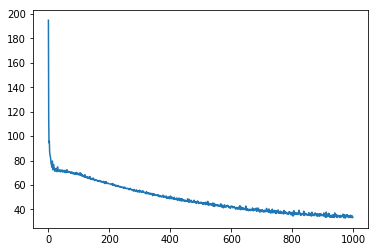

In [100]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

m (50, 3)


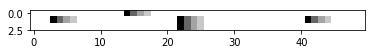

m (50, 3)


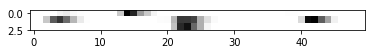

m (50, 3)


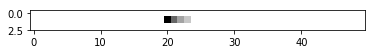

m (50, 3)


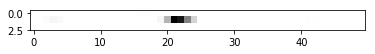

m (50, 3)


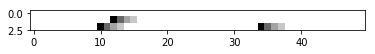

m (50, 3)


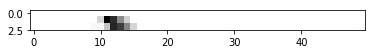

In [101]:
i = 0
j = 1
k = -1
x = vae.predict(x_train[:10])
plot.single(x_train[i, :50, :, 0])
plot.single(x[i, :50, :, 0])
plot.single(x_train[j, :50, :, 0])
plot.single(x[j, :50, :, 0])
plot.single(x_train[k, :50, :, 0])
plot.single(x[k, :50, :, 0])

In [102]:
x.shape

(10, 100, 3, 1)

m (30, 3)


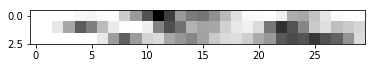

In [103]:
# interpolate - mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

m (30, 3)


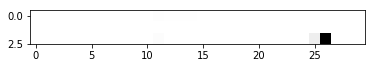

In [72]:
# interpolate - min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

In [73]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)

In [74]:
x_test.shape

(100, 100, 3, 1)

In [75]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(100, 2)

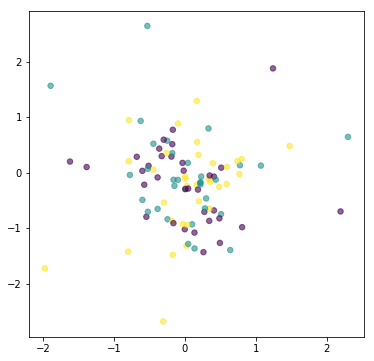

In [79]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], c=y_test, alpha=0.6, s=30)

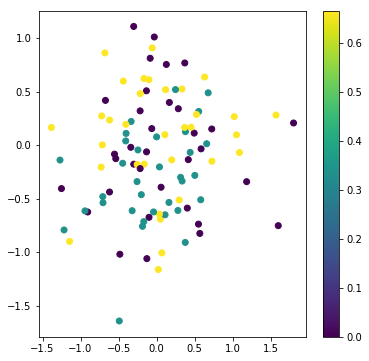

In [77]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [78]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

In [50]:
# x_decoded[0].reshape(150,3)

In [51]:
# display a 2D manifold of the digits
n = 3  # figure with 15x15 digits
digit_size1 = x_decoded.shape[-2]
digit_size2 = x_decoded.shape[-1]
figure = np.zeros((digit_size1 * n, digit_size1 * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size1, digit_size2)
        figure[i * digit_size1: (i + 1) * digit_size1,
               j * digit_size2: (j + 1) * digit_size2] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

NameError: name 'x_decoded' is not defined